# Using our M15 data (Hoffman et al. 2020)

This code below is a helper to recover the data used presented in Hoffman et al. 2020. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIPS

## (1) Data table
This data table contains all information we used to analyze the data.<br>
Table A1 in Hoffman et al. is a subset of this full table.

In [2]:
summary = pd.read_csv(f'summary_ver13.csv').set_index('id').sort_values(by='id')

In [3]:
summary.columns

Index(['M15_1_Ndata', 'M15_1_amplitude', 'M15_1_chi2/N', 'M15_1_data_avg_err',
       'M15_1_dec', 'M15_1_dist', 'M15_1_fname', 'M15_1_period',
       'M15_1_period_err', 'M15_1_ra', 'M15_2_Ndata', 'M15_2_amplitude',
       'M15_2_chi2/N', 'M15_2_data_avg_err', 'M15_2_dec', 'M15_2_dist',
       'M15_2_fname', 'M15_2_period', 'M15_2_period_err', 'M15_2_ra',
       'M15_3_Ndata', 'M15_3_amplitude', 'M15_3_chi2/N', 'M15_3_data_avg_err',
       'M15_3_dec', 'M15_3_dist', 'M15_3_fname', 'M15_3_period',
       'M15_3_period_err', 'M15_3_ra', 'M15_4_Ndata', 'M15_4_amplitude',
       'M15_4_chi2/N', 'M15_4_data_avg_err', 'M15_4_dec', 'M15_4_dist',
       'M15_4_fname', 'M15_4_period', 'M15_4_period_err', 'M15_4_ra', 'period',
       'period_err', 'amplitude', 'N_data', 'chi2/N', 'data_mag_mean_err',
       'dist_to_GCVS_deg', 'field', 'pick_method', 'H&M_id', 'ra', 'dec',
       'p_corwin', 'p_silbermann', 'p_ferro', 'p_siegel', 'priors_mag_upper',
       'priors_mag_lower', 'priors_period_gue

In [4]:
# Table A1
summary[['ra','dec','period','period_err','amplitude','mean_mag','type']]

ra        dec    period    period_err  amplitude   mean_mag  \
id                                                                          
V001  322.458958  12.173970  1.437837  3.661651e-07      1.071  14.987350   
V002  322.443774  12.168692  0.684304  1.601163e-07      0.488  15.741276   
V003  322.422192  12.153865  0.388721  8.549906e-06      0.484  15.828362   
V004  322.460962  12.121596  0.313589  2.414403e-08      0.626  15.919276   
V005  322.464627  12.108085  0.384212  7.214155e-08      0.536  15.783994   
...          ...        ...       ...           ...        ...        ...   
V150  322.494954  12.171465  1.043201  1.134967e-05      0.298  13.148673   
V152         NaN        NaN       NaN           NaN        NaN        NaN   
V154  322.491594  12.170759  0.864274  3.178918e-07      0.396  13.001821   
V155  322.490656  12.169706  0.911891  2.661795e-07      0.426  14.773248   
V158  322.467559  12.103084  0.118083  9.705817e-09      0.677  19.970945   

         type  
id             
V001  Cepheid  
V002     RRab  
V003      RRc  
V004      RRc  
V005      RRc  
...       ...  
V150       ??  
V152      NaN  
V154       ??  
V155  Cepheid  
V158       ??  

[169 rows x 7 columns]

## (2) Photometry data
We recommend taking a look at https://github.com/SterlingYM/PIPS for the usage of PIPS ```photdata``` object.

In [5]:
def getdata_filtered(name):
    path = summary.loc[name,'field']+'/summary/'+summary.loc[name,'H&M_id'][-3:]+'.dat'
    period = summary.loc[name]['period']
    data_V = PIPS.data_readin_LPP(path,filter='V')
    data_B = PIPS.data_readin_LPP(path,filter='B')
    
    # B-V estimate: mean difference of B-band against the nearest available V-band observations
    B_V = np.mean([(data_B[1][i]-data_V[1][abs(data_V[0]-data_B[0][i]).argmin()]) for i in range(len(data_B[1]))])
                   
    # prepare to cut bad datapoints
    err_threshold = None if np.isnan(summary.loc[name,'err_cut']) else summary.loc[name,'err_cut']
    mag_upper = None if np.isnan(summary.loc[name]['priors_mag_upper']) else summary.loc[name]['priors_mag_upper']
    mag_lower = None if np.isnan(summary.loc[name]['priors_mag_lower']) else summary.loc[name]['priors_mag_lower']

    # construct PIPS photdata object
    original = PIPS.photdata(data_V)
    original.err_cut_threshold = err_threshold
    filtered = original.phot_err_cut().phot_mag_cut(mag_upper,mag_lower)
    filtered.period = period
    filtered.label = name
    filtered.B_V = B_V
    
    # characteristic intrinsic scatter: see section 2.2.2 in our paper
    new_yerr = []
    for i in filtered.yerr:
        new_yerr.append(0.03 if i<0.03 else i)
    filtered.yerr = np.array(new_yerr)
    filtered.mag_err = filtered.yerr
        
    return filtered

### example 1

Text(0, 0.5, '$V$ [mag]')

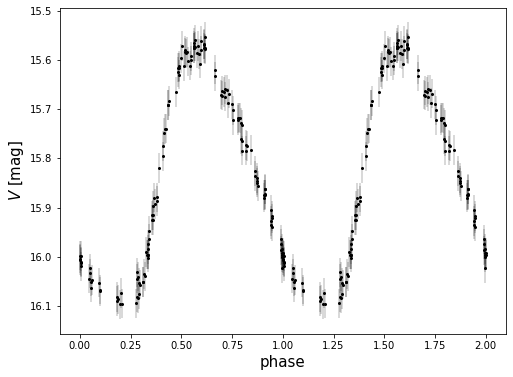

In [6]:
# pick a star
name = 'V003'

# get data
phot_obj = getdata_filtered(name)

# plot data
period   = phot_obj.period
x_folded = phot_obj.x % period
y        = phot_obj.y
yerr     = phot_obj.yerr
fig,ax = plt.subplots(1,1,figsize=(8,6))
markers1, caps1, bars1 = ax.errorbar(x_folded/period,y,yerr,ms=2,c='k',fmt='o')
markers2, caps2, bars2 = ax.errorbar(x_folded/period+1,y,yerr,ms=2,c='k',fmt='o')

# cosmetic settings
[bar.set_alpha(0.2) for bar in bars1]
[bar.set_alpha(0.2) for bar in bars2]
[cap.set_alpha(0.2) for cap in caps1]
[cap.set_alpha(0.2) for cap in caps2]
ax.invert_yaxis()
ax.set_xlabel('phase',fontsize=15)
ax.set_ylabel(r'$V$ [mag]',fontsize=15)

### example 2

In [7]:
# get data
phot_obj = getdata_filtered('V009')

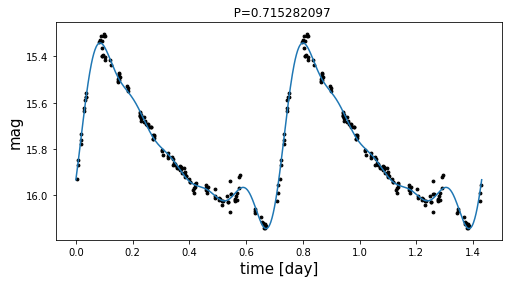

In [8]:
phot_obj.plot_lc_folded(phot_obj.period)